## Is the Swiss franc a safe haven for US investors during recessions?

We focus on the recessions of the last 40 years namely:
1. July 1981- November 1982
2. July 1990 - March 1991
3. March 2001 - November 2001
4. December 2007 - June 2009
5. February 2020 - today. 

Using the S&P 500 returns over these periods and the exchange rate USD/CHF, we investigate wether there is a significant correlation which could be exploited as an alternative and safe investment during recessions.

Load relevant libraries to be used throughout:
- **datetime**: for date handling and manipulation
- **matplotlib**: for plotting
- **numpy**: for data smoothing
- **scipy.stats**: for finding the pearson correlation
- **pandas**: to easily work with the data
- **yfinance**: to obtain historical stock price data
- **math**: to use mathematical functions (e.g. ```log(...)```)

In [17]:
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import yfinance
import math

Through Yahoo! Finance API "wrapper" (yfinance) we create a function to obtain historical data of an asset price at close and return it as a pandas dataframe object.

In [2]:
"""
   Returns historical data of the closing price of ticker between start and end.
   If not passed in, start is set to 01/01/1900 and end the date of today.
   Another optional argument is the frequency which is set to 1 day by default.

   :param string ticker: ticker of the asset which must match the one in yahoo finance
   :param string start: start date of the historical data to be retrived
   :param string end: end date of the historical data to be retrived
   :param string frequency: the epoch between each data point
   :return: historical price at close of ticker between start and end
   :rtype: pandas dataframe
"""
def get_historical_data(ticker, start_date="1900-01-01", end_date=datetime.today().strftime("%Y-%m-%d"), frequency="1d"):
    if start_date > end_date:
        raise Exception("start date cannot be before end date")
    asset = yfinance.Ticker(ticker)
    stock_history = asset.history(period="max", interval=frequency)
    stock_history['Date'] = stock_history.index.strftime("%Y-%m-%d")
    stock_history.reset_index(drop=True, inplace=True)
    filtered_data = stock_history.loc[(stock_history["Date"] >= start_date) & (
        stock_history["Date"] <= end_date)][["Date", "Close"]]

    return filtered_data

In theory, we could make use of the function ```get_historical_data(...)``` to obtain historical rates for the pair USD/CHF. However, the earliest data point starts in 2003 which would not be enough to analyze the first three recessions. Therefore, we load an excel file to a pandas dataframe with the historical rates of the pair considered. The data was retrieved from Bloomberg.

In [3]:
"""
   Returns historical data of the closing price of the pair USD/CHF between start and end.
   If not passed in, start is set to 01/01/1900 and end the date of today.

   :param string start: start date of the historical data to be retrived
   :param string end: end date of the historical data to be retrived
   :return: historical price at close of ticker between start and end
   :rtype: pandas dataframe
"""
def load_USDCHF_historical_data(start_date="1900-01-01", end_date=datetime.today().strftime("%Y-%m-%d")):
    if start_date > end_date:
        raise Exception("start date cannot be before end date")
    pair_data = pd.read_excel("USDCHF.xlsx").sort_values(by="Date", ascending=True)
    pair_data["Date"] = pair_data["Date"].map(lambda x: x.strftime("%Y-%m-%d"))
    return pair_data.loc[(pair_data["Date"] >= start_date) & (
        pair_data["Date"] <= end_date)][["Date", "Close"]]


Calculate log-returns of asset and define a mapping to be used in the dataframe manipulation.

In [4]:
def log_returns(stock_prices):
    mapping = {stock_prices[0] : 0}
    for i in range(1, len(stock_prices)):
        mapping[stock_prices[i]] = math.log(stock_prices[i] / stock_prices[i-1])
    return mapping

Obtain all the relevant data for all the 5 recessions and ensure dates match (CHF/USD had more data points than SPX which needed to be removed).

In [5]:
recession_dates = [["1981-07-01", "1982-11-01"],
                   ["1990-07-01", "1991-03-01"],
                   ["2001-03-01", "2001-11-01"],
                   ["2007-12-01", "2009-06-01"],
                   ["2020-02-01", "2022-11-21"]]

spx_yf_ticker = "^GSPC"
spx_historical_data = {}
fx_pair_historical_data = {}
n_recession = 0

for recession_date in recession_dates:
    n_recession += 1
    start_date = recession_date[0]
    end_date = recession_date[1]
    
    spx_data = get_historical_data(spx_yf_ticker, start_date, end_date)
    pair_data = load_USDCHF_historical_data(start_date, end_date)

    # replace stock prices with log returns 
    spx_data["Close"] = spx_data["Close"].map(
        log_returns(list(spx_data["Close"])))
    spx_data.index = range(len(spx_data.index))

    
    # clean fx pair data
    pair_data = pair_data[pair_data["Date"].isin(spx_data["Date"])]
    # similarly for pair rates, replace with log returns
    pair_data["Close"] = pair_data["Close"].map(
        log_returns(list(pair_data["Close"])))
    pair_data.index = range(len(pair_data.index))

    spx_historical_data[f"recession {n_recession}"] = spx_data
    fx_pair_historical_data[f"recession {n_recession}"] = pair_data

For each recession visualize the returns of SPX and USD/CHF (serves also as a sanity check).

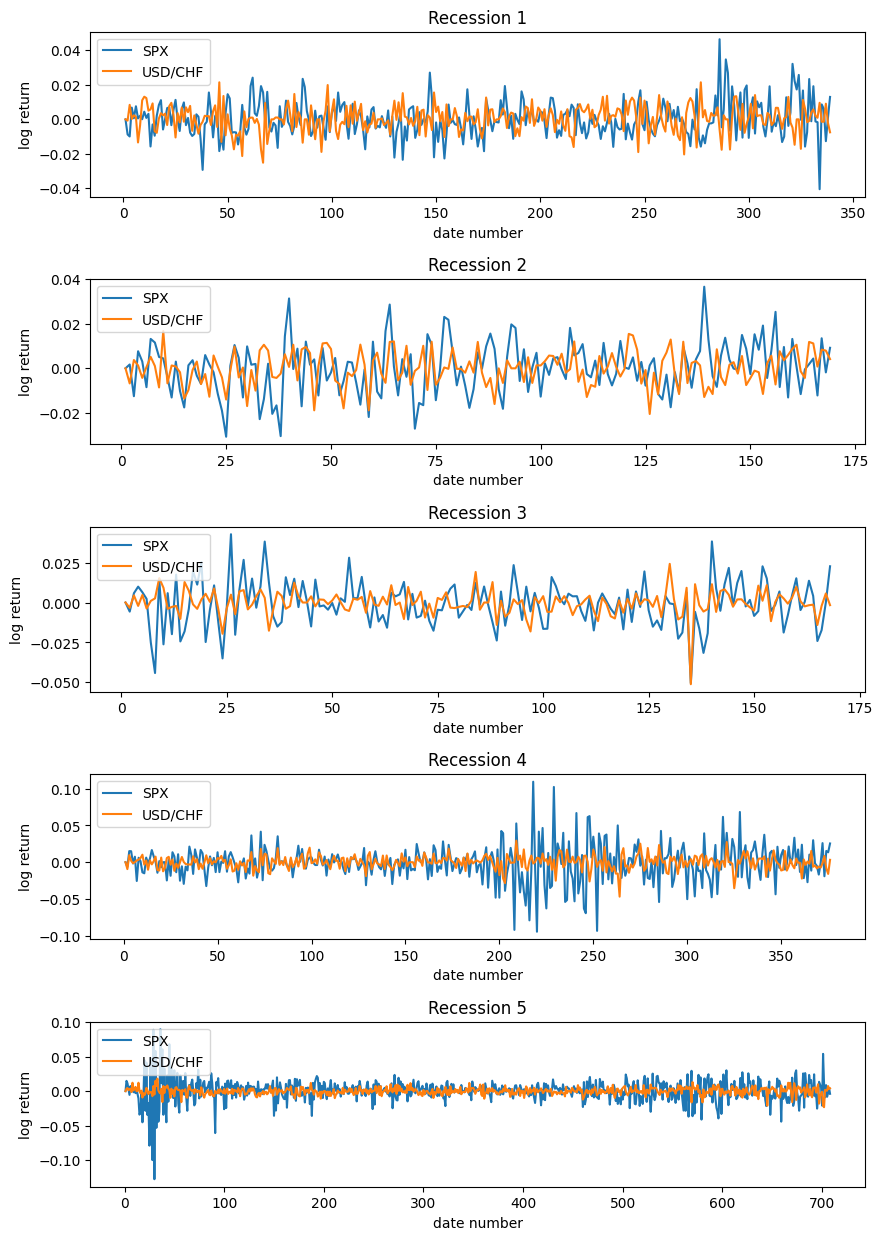

In [6]:
fig, axs = plt.subplots(5, figsize=(10, 15), gridspec_kw={'hspace': 0.5, 'wspace': 0.9})

for i in range(len(recession_dates)):
    date_nr = list(
        range(1, len(spx_historical_data[f"recession {i+1}"]["Date"]) + 1))
    axs[i].plot(
        date_nr, list(spx_historical_data[f"recession {i+1}"]["Close"]))
    axs[i].plot(
        date_nr, list(fx_pair_historical_data[f"recession {i+1}"]["Close"]))
    axs[i].legend(["SPX", "USD/CHF"], loc='upper left')
    axs[i].set_ylabel('log return')
    axs[i].set_xlabel('date number')
    axs[i].set_title(f'Recession {i+1}')


Use a low-pass filter to smooth the data, specifically a moving average filter (Kalman is also possible) and plot.

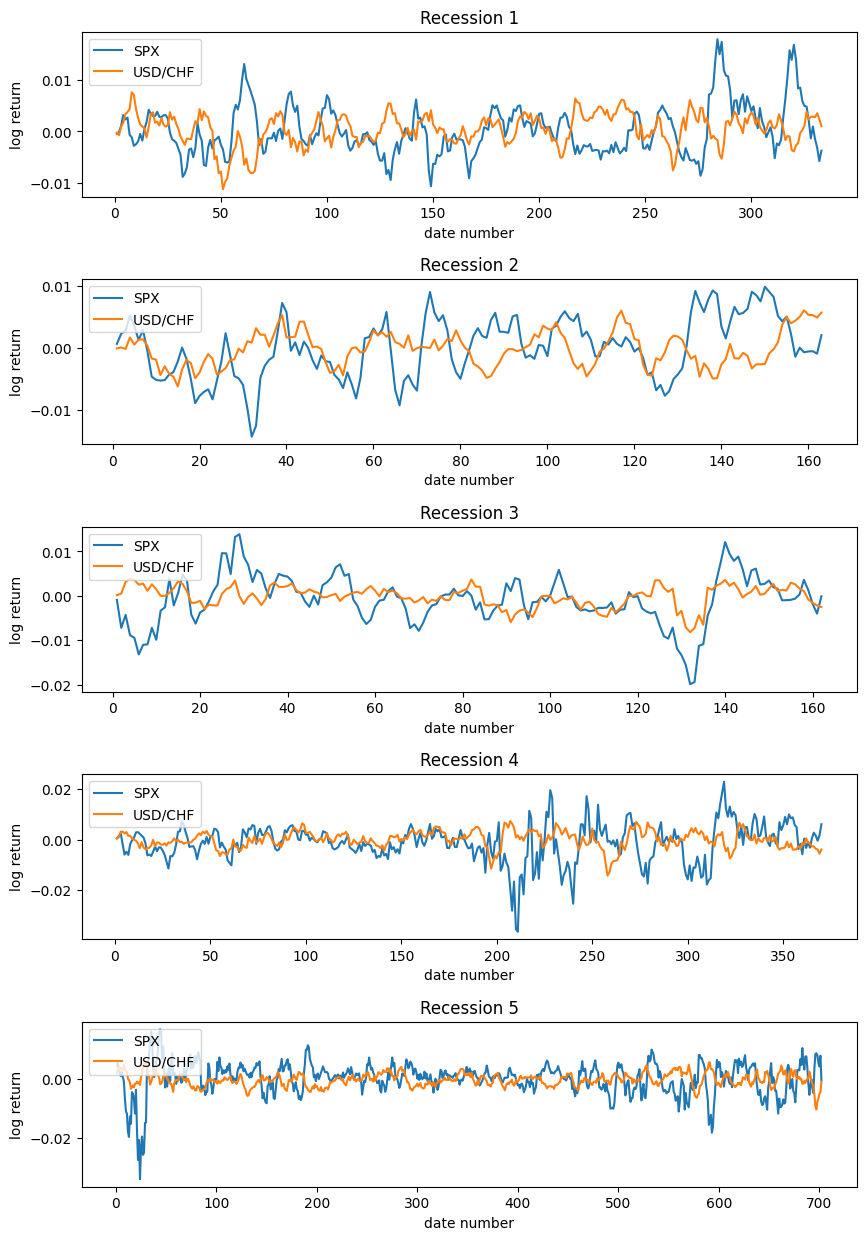

In [16]:
from scipy.stats import spearmanr
import numpy as np
fig, axs = plt.subplots(5, figsize=(10, 15), gridspec_kw={
                        'hspace': 0.5, 'wspace': 0.9})

smoothed_data_per_recession = []

for i in range(len(recession_dates)):
    X = list(spx_historical_data[f"recession {i+1}"]["Close"])
    Y = list(fx_pair_historical_data[f"recession {i+1}"]["Close"])

    # moving average (7 day window)
    smoothed_data_X = np.convolve(X, np.ones((7,))/7, mode='valid')
    smoothed_data_Y = np.convolve(Y, np.ones((7,))/7, mode='valid')

    smoothed_data_per_recession.append([smoothed_data_X, smoothed_data_Y])
    
    date_nr = list(
        range(1, len(smoothed_data_X) + 1))
    axs[i].plot(
        date_nr, list(smoothed_data_X))
    axs[i].plot(
        date_nr, list(smoothed_data_Y))
    axs[i].legend(["SPX", "USD/CHF"], loc='upper left')
    axs[i].set_ylabel('log return')
    axs[i].set_xlabel('date number')
    axs[i].set_title(f'Recession {i+1}')


For each recession find the spearman correlation.

In [14]:
for i in range(len(recession_dates)):
    X = smoothed_data_per_recession[i][0]
    Y = smoothed_data_per_recession[i][1]

    pearson_corr, pearson_p_value = pearsonr(X, Y)
    print(f"Recession {i+1}:\n\tCorrelation: {pearson_corr},\n\t P-value:    {pearson_p_value}")
    

Recession 1:
	Correlation: -0.26382769309288123,
	 P-value:    1.044380900228916e-06
Recession 2:
	Correlation: 0.01300623359816306,
	 P-value:    0.8691159516864073
Recession 3:
	Correlation: 0.34411909183959677,
	 P-value:    7.335485647972713e-06
Recession 4:
	Correlation: -0.15325929751954845,
	 P-value:    0.003121567543097755
Recession 5:
	Correlation: -0.357822438140928,
	 P-value:    1.2467813967490195e-22
